Best Solution: [5, 3, 4, 5, 4, 1, 5, 5, 5, 3, 4]


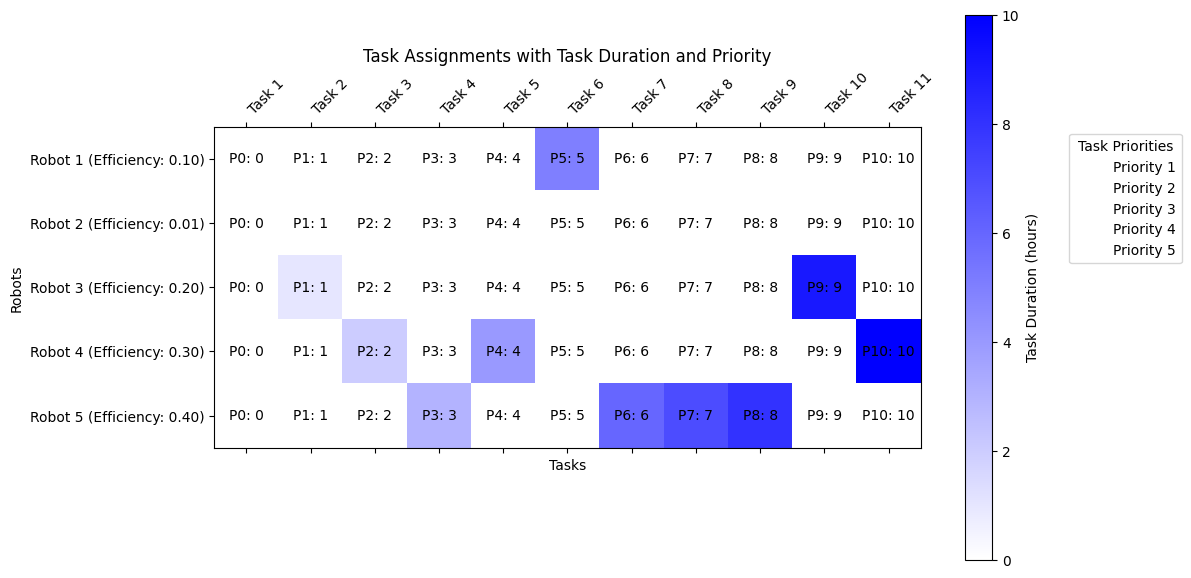

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

np.random.seed(42)

# Generate test data
task_durations = [x for x in range(11)]# Task durations
task_priorities = [x for x in range(11)]   # Task priorities
robot_efficiencies = [0.1,0.01,0.2,0.3,0.4] # Robot efficiencies
k=3
population_size = 50
n_generations = 100
mutation_rate = 0.1

class GeneticAlgorithm:
    def __init__(self, num_tasks, num_robots, tasks, robots, population_size=100, crossover_rate=0.3, mutation_rate=0.01, generations=100, tournament_size=5):
        self.num_tasks = num_tasks
        self.num_robots = num_robots
        self.tasks = tasks
        self.robots = robots
        self.population_size = population_size
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.generations = generations
        self.tournament_size = tournament_size
        self.population = self.initialize_population()

    def initialize_population(self):
        population = []
        for _ in range(self.population_size):
            individual = [random.randint(1, self.num_robots) for _ in range(self.num_tasks)]
            population.append(individual)
        return population

    def calculate_total_production_time(self, individual):
        robot_times = [0] * self.num_robots
        for i in range(self.num_tasks):
            robot_times[individual[i] - 1] += self.tasks[i] / self.robots[individual[i] - 1]
        return max(robot_times)

    def calculate_workload_balance(self, individual):
        robot_times = [0] * self.num_robots
        for i in range(self.num_tasks):
            robot_times[individual[i] - 1] += self.tasks[i] / self.robots[individual[i] - 1]
        mean_time = np.mean(robot_times)
        deviation = np.std(robot_times)
        return deviation

    def fitness_function(self, individual):
        T_total = self.calculate_total_production_time(individual)
        B = self.calculate_workload_balance(individual)
        return T_total + B  # Minimize both T_total and B

    def selection(self, population):
        fitness_values = [self.fitness_function(individual) for individual in population]
        total_fitness = sum(fitness_values)
        probabilities = [fitness / total_fitness for fitness in fitness_values]
        selected_indices = np.random.choice(range(len(population)), size=len(population), replace=True, p=probabilities)
        selected_individuals = [population[i] for i in selected_indices]
        return selected_individuals

    def crossover(self, parent1, parent2, crossover_rate=0.9):
        if random.random() < crossover_rate:
            crossover_point = random.randint(1, len(parent1) - 1)
            child1 = parent1[:crossover_point] + parent2[crossover_point:]
            child2 = parent2[:crossover_point] + parent1[crossover_point:]
            return child1, child2
        else:
            return parent1, parent2

    def mutation(self, individual, mutation_rate=mutation_rate):
        if random.random() < mutation_rate:
            mutation_point = random.randint(0, self.num_tasks - 1)
            individual[mutation_point] = random.randint(1, self.num_robots)
        return individual

    def evolve(self):
        for generation in range(self.generations):
            selected_individuals = self.tournament_selection(self.population, self.fitness_function, k)
            offspring = []
            for i in range(0, len(selected_individuals), 2):
                parent1 = selected_individuals[i]
                parent2 = selected_individuals[i + 1]
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutation(child1)
                child2 = self.mutation(child2)
                offspring.extend([child1, child2])
            self.population = offspring

        # Return the best individual found
        best_individual = min(self.population, key=self.fitness_function)
        return best_individual

    def tournament_selection(self, population, fitness_function, k):
        selected_individuals = []
        for _ in range(self.population_size):
            tournament_contestants = random.sample(population, self.tournament_size)
            winner = min(tournament_contestants, key=fitness_function)
            selected_individuals.append(winner)
        return selected_individuals

def visualize_assignments_improved(solution, task_durations, task_priorities, robot_efficiencies):
    # Create a grid for visualization based on the solution provided
    grid = np.zeros((len(robot_efficiencies), len(task_durations)))
    for task_idx, robot_idx in enumerate(solution):
        grid[robot_idx - 1, task_idx] = task_durations[task_idx]  # Subtract 1 from robot_idx

    fig, ax = plt.subplots(figsize=(12, 6))
    cmap = mcolors.LinearSegmentedColormap.from_list("", ["white", "blue"])  # Custom colormap

    # Display the grid with task durations
    cax = ax.matshow(grid, cmap=cmap)
    fig.colorbar(cax, label='Task Duration (hours)')

    # Annotate each cell with task priority and duration
    for i in range(len(robot_efficiencies)):
        for j in range(len(task_durations)):
            #if grid[i, j] != 0:
                ax.text(j, i, f'P{task_priorities[j]}: {task_durations[j]}', ha='center', va='center', color='black')

    # Set the ticks and labels for tasks and robots
    ax.set_xticks(np.arange(len(task_durations)))
    ax.set_yticks(np.arange(len(robot_efficiencies)))
    ax.set_xticklabels([f'Task {i+1}' for i in range(len(task_durations))], rotation=45, ha="left")
    ax.set_yticklabels([f'Robot {i+1} (Efficiency: {eff:.2f})' for i, eff in enumerate(robot_efficiencies)])

    plt.xlabel('Tasks')
    plt.ylabel('Robots')
    plt.title('Task Assignments with Task Duration and Priority')

    # Create a legend for task priorities
    priority_patches = [mpatches.Patch(color='white', label=f'Priority {i}') for i in range(1, 6)]
    plt.legend(handles=priority_patches, bbox_to_anchor=(1.20, 1), loc='upper left', title="Task Priorities")

    plt.tight_layout()
    plt.show()

def generate_mock_data(num_tasks=10, num_robots=5):
    task_durations = [x for x in range(11)]# Task durations
    task_priorities = [x for x in range(11)]   # Task priorities
    robot_efficiencies = [0.1,0.01,0.2,0.3,0.4] # Robot efficiencies
    return task_durations, task_priorities, robot_efficiencies


def run_genetic_algorithm(task_durations, task_priorities, robot_efficiencies):
    num_tasks = len(task_durations)
    num_robots = len(robot_efficiencies)
    ga = GeneticAlgorithm(num_tasks, num_robots, task_durations, robot_efficiencies)
    best_solution = ga.evolve()
    print("Best Solution:", best_solution)
    return best_solution


# Main execution
if __name__ == "__main__":
    num_tasks = 10
    num_robots = 5
    task_durations, task_priorities, robot_efficiencies = generate_mock_data(num_tasks, num_robots)

    # Run GA to find the best solution
    best_solution = run_genetic_algorithm(task_durations, task_priorities, robot_efficiencies)

    # Visualize the initial random assignment
    visualize_assignments_improved(best_solution, task_durations, task_priorities, robot_efficiencies)